### <center>Chestnut Bur Detection and Segmentation using MaskRCNN in PyTorch</center>

In [1]:
%matplotlib inline

import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, Subset, DataLoader
import torchvision
from torchvision import transforms as _transforms, tv_tensors
from torchvision.ops import FrozenBatchNorm2d
import torchvision.transforms.v2 as T
from torchvision.models.detection import MaskRCNN, rpn
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import json
from matplotlib import patches
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image, ImageDraw
import numpy as np
from pathlib import Path
import gc
import os
import random

##### <center> Load the image and annotation data </center>

In [2]:
# load annotations from json file
annos = json.load(open("S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/route9_orchard3/data/_annotations.coco.json"))

In [3]:
# convert the annos dict to a df
annos_df = pd.DataFrame(annos["annotations"])
df = pd.DataFrame()
df["tree_id"] = annos_df["image_id"].apply(lambda x: annos["images"][x]["file_name"].split("_")[0])
df["file_name"] = annos_df["image_id"].apply(lambda x: annos["images"][x]["file_name"])
df["file_name"] = df["file_name"].apply(lambda x: x.split("_")[0] + ".png")
categories = [cat["name"] for cat in annos["categories"]]
df["category_name"] = annos_df["category_id"].apply(lambda x: categories[x])
df["bbox"] = annos_df["bbox"].apply(lambda x: torch.tensor(x))
df["area"] = annos_df["area"].apply(lambda x: torch.tensor(x))
df["segmentation"] = annos_df["segmentation"].apply(lambda x: torch.tensor(x))
df["iscrowd"] = annos_df["iscrowd"]

reviewed_trees = [392, 60, 44, 91, 272, 51, 152, 329, 286, 320, 280, 366, 304] # subset for testing 

df = df[df["tree_id"].isin([str(tree_id) for tree_id in reviewed_trees])]

In [4]:
image_dir = "S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/route9_orchard3/data/images"
image_names = df["file_name"].unique()

##### <center> Pre-process image and annotation data </center>

##### Adapted from: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#an-instance-segmentation-model-for-pennfudan-dataset

In [5]:
def create_polygon_mask(mask, polys, color):
    for poly in polys:
        # Create a PIL Image object to use ImageDraw
        poly_mask = Image.new("L", (mask.shape[1], mask.shape[0]), 0)
        ImageDraw.Draw(poly_mask).polygon(poly, fill=color)  # Directly pass the list of tuples
        poly_mask = np.array(poly_mask)
        mask = np.maximum(mask, poly_mask)
    return mask

# # Define the output directories
# preprocessed_image_dir = Path('S:\\Zack\\Deep Learning\\Chestnut_Bur_Instance_Segmentation\\route9_orchard3\\data\\preprocessed\\images')
# bbox_image_dir = Path('S:\\Zack\\Deep Learning\\Chestnut_Bur_Instance_Segmentation\\route9_orchard3\\data\\preprocessed\\images_with_boxes')
# mask_output_dir = Path('S:\\Zack\\Deep Learning\\Chestnut_Bur_Instance_Segmentation\\route9_orchard3\\data\\preprocessed\\masks')

# # Ensure the output directories exist
# preprocessed_image_dir.mkdir(parents=True, exist_ok=True)
# bbox_image_dir.mkdir(parents=True, exist_ok=True)
# mask_output_dir.mkdir(parents=True, exist_ok=True)

# # Initialize a list to store the preprocessed data
# preprocessed_data = []

# # Loop through all file names in the DataFrame
# for file_name in df["file_name"].unique():
#     try:
#         print(f"Processing file: {file_name}")
        
#         # Filter the DataFrame for the current file name
#         row = df[df["file_name"] == file_name]
#         image_path = Path(image_dir) / row["file_name"].values[0]
#         image = Image.open(image_path).convert('RGB')
#         image_np = np.array(image)  # Convert image to [H, W, 3]

#         # Process Canopy Polygon
#         canopy_poly = row[row["category_name"] == "Canopy"]["segmentation"].values
#         canopy_poly = [np.array(poly[0]).reshape(-1, 2).tolist() for poly in canopy_poly]
#         canopy_poly = [[tuple(p) for p in poly] for poly in canopy_poly]  # Convert to list of tuples for PIL
#         canopy_mask = np.zeros((image_np.shape[0], image_np.shape[1]), dtype=np.uint8)
#         canopy_mask = create_polygon_mask(canopy_mask, canopy_poly, 1)

#         # Process Chestnut-burr Polygons
#         bur_poly = row[row["category_name"] == "Chestnut-burr"]["segmentation"].values
#         bur_poly = [np.array(poly[0]).reshape(-1, 2).tolist() for poly in bur_poly]
#         bur_poly = [[tuple(p) for p in poly] for poly in bur_poly]  # Convert to list of tuples for PIL
#         bur_masks = []
#         for poly in bur_poly:
#             mask = np.zeros((image_np.shape[0], image_np.shape[1]), dtype=np.uint8)
#             mask = create_polygon_mask(mask, [poly], 1)
#             bur_masks.append(mask)
#         mask_image = np.stack(bur_masks, axis=0)

#         # Ensure the image and masks have compatible shapes
#         mask_image = mask_image.transpose(1, 2, 0)  # Convert masks to [H, W, N]

#         # Crop the image using NumPy slicing
#         canopy_bbox = row[row["category_name"] == "Canopy"]["bbox"].values[0]
#         padding = 50.0
#         padded_bbox = [
#             max(0, int(canopy_bbox[0] - padding)),
#             max(0, int(canopy_bbox[1] - padding)),
#             min(image_np.shape[1], int(canopy_bbox[0] + canopy_bbox[2] + padding)),
#             min(image_np.shape[0], int(canopy_bbox[1] + canopy_bbox[3] + padding))
#         ]
#         image_cropped = image_np[padded_bbox[1]:padded_bbox[3], padded_bbox[0]:padded_bbox[2]]

#         # Crop the masks using NumPy slicing
#         mask_cropped = mask_image[padded_bbox[1]:padded_bbox[3], padded_bbox[0]:padded_bbox[2], :]

#         # Sum the masks along the last axis
#         mask_cropped_sum = np.sum(mask_cropped, axis=2)

#         # Fill the background with black where the canopy mask is not present
#         fill_color = [0, 0, 0]  # RGB for black
#         canopy_mask_cropped = canopy_mask[padded_bbox[1]:padded_bbox[3], padded_bbox[0]:padded_bbox[2]].astype(bool)
#         for c in range(3):
#             image_cropped[:, :, c][~canopy_mask_cropped] = fill_color[c]

#         # Convert the image to a tensor and normalize
#         transform = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
#         image_cropped = transform(image_cropped).permute(1, 2, 0).numpy()  # Normalize and convert back to [H, W, C]

#         # Save the preprocessed image as a .npy file
#         preprocessed_image_path = preprocessed_image_dir / f'{Path(file_name).stem}.npy'
#         np.save(preprocessed_image_path, image_cropped)

#         # Save the multi-channel mask as a .npz file
#         mask_image_path = mask_output_dir / f'{Path(file_name).stem}.npz'
#         np.savez_compressed(mask_image_path, mask_cropped)

#         # Plot the bounding boxes on the preprocessed image at 100% scale and save
#         fig, ax = plt.subplots(1, figsize=(image_cropped.shape[1] / 100, image_cropped.shape[0] / 100), dpi=100)
#         ax.imshow(image_cropped)

#         # Add bounding boxes and store them in preprocessed_data
#         for bbox in row[row["category_name"] == "Chestnut-burr"]["bbox"].values:
#             rect = patches.Rectangle(
#                 (bbox[0] - padded_bbox[0], bbox[1] - padded_bbox[1]),
#                 bbox[2],
#                 bbox[3],
#                 linewidth=0.5,
#                 edgecolor='r',
#                 facecolor='none'
#             )
#             ax.add_patch(rect)
#             preprocessed_data.append({
#                 "tree_id": row["tree_id"].values[0],
#                 "file_name": file_name,
#                 "bbox_x": float(bbox[0] - padded_bbox[0]),
#                 "bbox_y": float(bbox[1] - padded_bbox[1]),
#                 "bbox_w": float(bbox[2]),
#                 "bbox_h": float(bbox[3]),
#                 "category_name": "Chestnut-burr",
#                 "iscrowd": int(row["iscrowd"].values[0])
#             })

#         plt.axis('off')
#         bbox_image_path = bbox_image_dir / f'{file_name}'
#         plt.savefig(bbox_image_path, bbox_inches='tight', pad_inches=0)
#         plt.close(fig)
        
#     except Exception as e:
#         print(f"Error processing file {file_name}: {e}")

# # Create a DataFrame from the preprocessed data
# preprocessed_df = pd.DataFrame(preprocessed_data)

# # Save the updated DataFrame to a CSV file
# updated_csv_path = 'S:\\Zack\\Deep Learning\\Chestnut_Bur_Instance_Segmentation\\route9_orchard3\\data\\preprocessed\\annotations.csv'
# preprocessed_df.to_csv(updated_csv_path, index=False)

In [1]:
class ChestnutBurSegmentation(Dataset):
    def __init__(self, images_dir, masks_dir, annotations_csv, transform=None):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.annotations = pd.read_csv(annotations_csv)
        self.transform = transform
        self.file_names = self.annotations["file_name"].unique()

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        file_name = self.file_names[idx]
        image_path = self.images_dir / f'{Path(file_name).stem}.npy'
        mask_path = self.masks_dir / f'{Path(file_name).stem}.npz'

        # Load the preprocessed image and mask
        image = np.load(image_path)
        mask = np.load(mask_path)['arr_0']

        # Convert image and mask to tv_tensors
        image = tv_tensors.Image(torch.tensor(image).permute(2, 0, 1))  # Convert to [C, H, W]
        mask = tv_tensors.Mask(torch.tensor(mask).permute(2, 0, 1))  # Convert to [C, H, W]

        # Get the annotations for the current file
        annotations = self.annotations[self.annotations["file_name"] == file_name]

        labels = [1] * len(annotations)  # All labels are "Chestnut-burr"
        bboxes = annotations[["bbox_x", "bbox_y", "bbox_w", "bbox_h"]].values
        bboxes = [torch.tensor([float(bbox[0]), float(bbox[1]), float(bbox[0] + bbox[2]), float(bbox[1] + bbox[3])], dtype=torch.float32) for bbox in bboxes]
        bboxes = torch.stack(bboxes, dim=0)
        iscrowd = annotations["iscrowd"].values
        area = (bboxes[:, 2] - bboxes[:, 0]) * (bboxes[:, 3] - bboxes[:, 1])

        # Create the target dictionary
        target = {
            "boxes": tv_tensors.BoundingBoxes(bboxes, format=tv_tensors.BoundingBoxFormat.XYXY, canvas_size=(image.shape[1], image.shape[2])),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([idx]),
            "area": area.clone().detach(),
            "iscrowd": torch.tensor(iscrowd, dtype=torch.uint8),
            "masks": mask
        }

        if self.transform:
            image, target = self.transform(image, target)

        return image, target

    @staticmethod
    def collate_fn(batch):
        return tuple(zip(*batch))

NameError: name 'Dataset' is not defined

In [7]:
# define transforms for the dataset
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomApply([T.RandomRotation(degrees=[-15, 15], fill=defaultdict(lambda: 0, {tv_tensors.Image: (0, 0, 0)}))], p=0.75)) # fill padded area in black
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomIoUCrop(min_scale=0.9, max_scale=1.1))
        transforms.append(T.RandomApply([T.ColorJitter(brightness=0.05, contrast=0.1, saturation=0.1, hue=0)], p=0.5))
    transforms.append(T.Resize(size=(540,), max_size=960, interpolation=T.InterpolationMode.BICUBIC))
    transforms.append(T.ClampBoundingBoxes()) # for segmentations too
    transforms.append(T.SanitizeBoundingBoxes()) # for segmentations too
    return T.Compose(transforms)

In [8]:
images_dir = 'S:\\Zack\\Deep Learning\\Chestnut_Bur_Instance_Segmentation\\route9_orchard3\\data\\preprocessed\\images'
masks_dir = 'S:\\Zack\\Deep Learning\\Chestnut_Bur_Instance_Segmentation\\route9_orchard3\\data\\preprocessed\\masks'
annotations_csv = 'S:\\Zack\\Deep Learning\\Chestnut_Bur_Instance_Segmentation\\route9_orchard3\\data\\preprocessed\\annotations.csv'

sample_ds = ChestnutBurSegmentation(images_dir, 
                                    masks_dir, 
                                    annotations_csv,
                                    transform = get_transform(train=True))

sample_dl = DataLoader(sample_ds, 
                       batch_size = 4, 
                       shuffle = True, 
                       collate_fn = ChestnutBurSegmentation.collate_fn)

In [9]:
# resized_bounding_boxes = []

# for images, targets in sample_dl:
#     for target in targets:
#         for box in target['boxes']:
#             resized_bounding_boxes.append(box)

# # Convert to numpy array
# resized_bounding_boxes = np.array(resized_bounding_boxes)

# # Print the resized bounding box dimensions
# print(resized_bounding_boxes[:5])

In [10]:
# from sklearn.cluster import KMeans

# # Convert to [width, height] format
# widths = resized_bounding_boxes[:, 2] - resized_bounding_boxes[:, 0]
# heights = resized_bounding_boxes[:, 3] - resized_bounding_boxes[:, 1]
# bounding_boxes_wh = np.stack((widths, heights), axis=1)

# # Perform k-means clustering to find anchor sizes
# num_clusters = 5  # Number of anchor sizes
# kmeans = KMeans(n_clusters=num_clusters, random_state=666).fit(bounding_boxes_wh)
# anchor_sizes = kmeans.cluster_centers_

# # Print the anchor sizes
# print("Anchor Sizes (width, height):")
# print(anchor_sizes)

# # Determine aspect ratios from the anchor sizes
# anchor_aspect_ratios = anchor_sizes[:, 0] / anchor_sizes[:, 1]

# # Print the aspect ratios
# print("Anchor Aspect Ratios:")
# print(anchor_aspect_ratios)

In [11]:
images, targets = next(iter(sample_dl))
images = [img for img in images]
targets = [{k: v for k, v in target.items()} for target in targets]

##### <center> Plot sample transformed images, targets, and masks </center>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11991041..1.0802493].


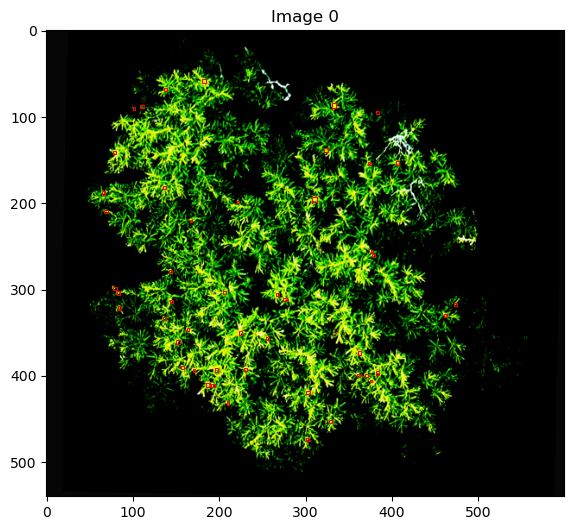

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.091937006..1.050248].


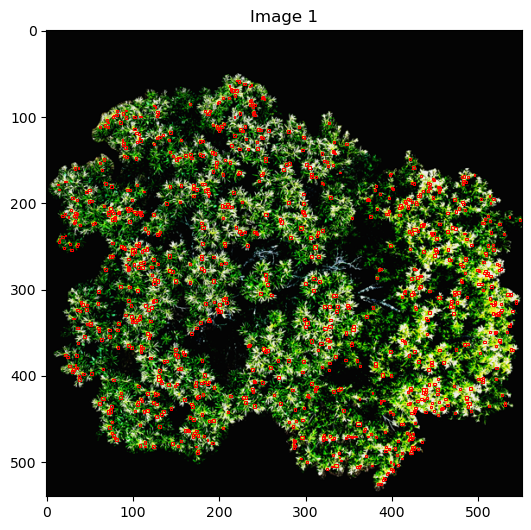

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3137944..2.4390323].


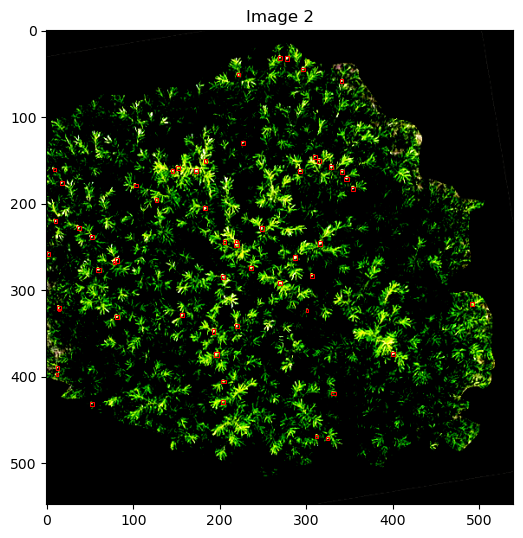

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.118884474..1.1198262].


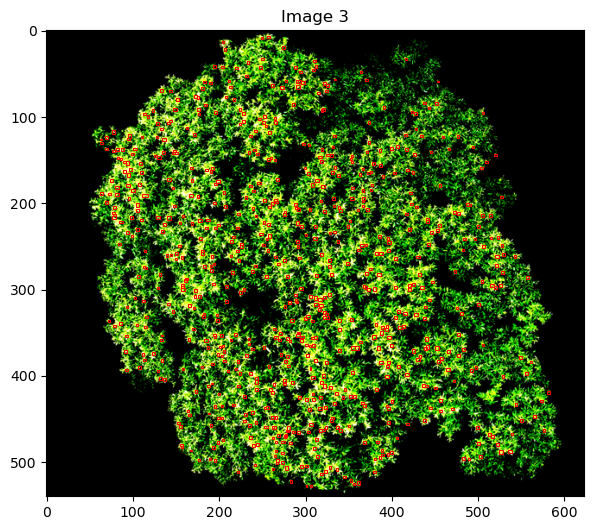

In [12]:
def plot_sample_images_and_targets(images, targets):
    batch_size = len(images)
    
    for i in range(batch_size):
        image = images[i]
        target = targets[i]

        # Convert from [C, H, W] to [H, W, C]
        image_np = image.permute(1, 2, 0).cpu().numpy()
        
        # Get the original resolution of the image
        height, width, _ = image_np.shape
        
        # Plot the image with original resolution
        fig, ax = plt.subplots(1, 1, figsize=(width / 100, height / 100), dpi=100)
        ax.imshow(image_np)
        ax.set_title(f"Image {i}")

        # Plot bounding boxes
        bboxes = target['boxes'].cpu().numpy()
        for bbox in bboxes:
            # bbox is in XYXY format, so we need to convert it to XYWH format for plotting
            x_min, y_min, x_max, y_max = bbox
            width = x_max - x_min
            height = y_max - y_min
            rect = plt.Rectangle((x_min, y_min), width, height, fill=False, color='red', linewidth=0.75)
            ax.add_patch(rect)

        plt.tight_layout()
        plt.show()

plot_sample_images_and_targets(images, targets)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11991041..1.0802493].


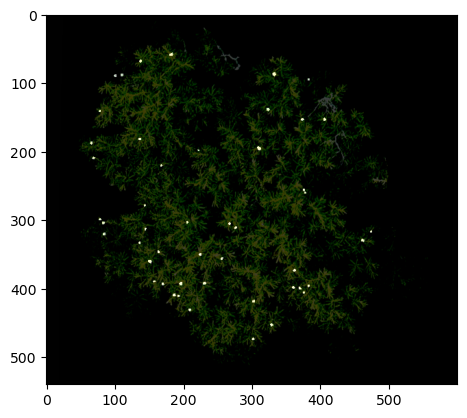

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.091937006..1.050248].


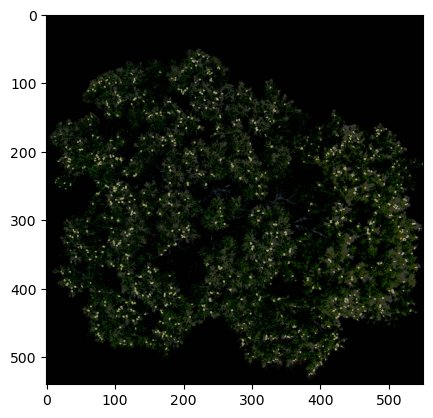

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3137944..2.4390323].


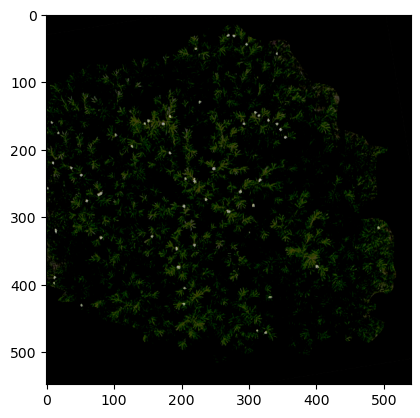

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.118884474..1.1198262].


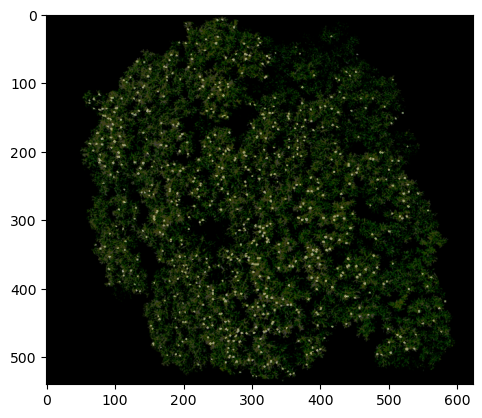

In [13]:
# plot each transformed image with its chestnut burr masks

for i, (image, target) in enumerate(zip(images, targets)):

    tree_id = target["image_id"]
    image = image.permute(1, 2, 0)
    mask = target["masks"].permute(1, 2, 0)

    #plot mask on image and save to .png file
    plt.imshow(image)
    plt.imshow(mask.sum(axis=2), cmap='gray', alpha=0.75)
    plt.show()

##### <center> Construct MaskRCNN Model </center>

In [14]:
def get_instance_segmentation_model(depth=18, trainable_backbone_layers=3, min_size=540, max_size=960, image_mean=[0, 0, 0], 
                                    image_std=[1, 1, 1], num_classes=2, box_score_thresh=0.5, box_nms_thresh=0.3,
                                    box_detections_per_img=1000):
    # Create the backbone with FPN
    if depth == 18:
        backbone = resnet_fpn_backbone(backbone_name='resnet18', 
                                       weights=torchvision.models.ResNet18_Weights.DEFAULT, 
                                       trainable_layers=trainable_backbone_layers
                                       )
    elif depth == 34:
        backbone = resnet_fpn_backbone(backbone_name='resnet34', 
                                       weights=torchvision.models.ResNet34_Weights.DEFAULT,
                                       trainable_layers=trainable_backbone_layers
                                       )
    elif depth == 50:
        backbone = resnet_fpn_backbone(backbone_name='resnet50', 
                                       weights=torchvision.models.ResNet50_Weights.DEFAULT,
                                       trainable_layers=trainable_backbone_layers
                                       )
    elif depth == 101:
        backbone = resnet_fpn_backbone(backbone_name='resnet101', 
                                       weights=torchvision.models.ResNet101_Weights.DEFAULT, 
                                       trainable_layers=trainable_backbone_layers
                                       )
    elif depth == 152:
        backbone = resnet_fpn_backbone(backbone_name='resnet152', 
                                       weights=torchvision.models.ResNet152_Weights.DEFAULT, 
                                       trainable_layers=trainable_backbone_layers
                                       )
    else:
        raise ValueError("Unsupported model depth")
    
    # anchor sizes and aspect ratios determined using Kmeans clustering on resized bounding boxes
    anchor_sizes = [(1,), (2,), (4,), (8,), (16,)] 
    anchor_aspect_ratios = [(0.99, 1.0, 1.01), (0.99, 1.0, 1.01), (0.99, 1.0, 1.01), (0.99, 1.0, 1.01), (0.99, 1.0, 1.01)]

    # Create the Mask R-CNN model with the custom backbone
    model = MaskRCNN(backbone, 
                     num_classes=num_classes,
                     min_size=min_size,
                     max_size=max_size,
                     image_mean=image_mean,
                     image_std=image_std,
                     rpn_anchor_generator=rpn.AnchorGenerator(sizes=anchor_sizes, aspect_ratios=anchor_aspect_ratios),
                     box_score_thresh=box_score_thresh,
                     box_nms_thresh=box_nms_thresh,
                     box_detections_per_img=box_detections_per_img
                     )

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one to reflect the number of classes
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    # Get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    # replace FrozenBatchNorm2d in the last two backbone layers with trainable batchNorm2d
    for name, module in model.backbone.body.named_modules():
        if 'layer3' in name or 'layer4' in name:
            if isinstance(module, FrozenBatchNorm2d):
                # Extract the number of features, mean, and variance from the FrozenBatchNorm2d
                num_features = module.weight.shape[0]  # Get the number of channels (features)
                running_mean = module.running_mean.clone()  # Extract running mean
                running_var = module.running_var.clone()    # Extract running variance

                # Create a new BatchNorm2d layer with the same number of features
                batch_norm = nn.BatchNorm2d(num_features)

                # Initialize BatchNorm2d with the extracted running mean and variance
                batch_norm.running_mean = running_mean
                batch_norm.running_var = running_var

                # Initialize the weights with a normal distribution (mean=1, std=0.02) for stability
                nn.init.normal_(batch_norm.weight, mean=1.0, std=0.02)  # Small normal distribution

                # Initialize the biases to zero (standard for BatchNorm2d)
                nn.init.constant_(batch_norm.bias, 0)

                # Replace the FrozenBatchNorm2d layer with BatchNorm2d
                parent_module_name = '.'.join(name.split('.')[:-1])  # Get the parent module name
                module_name = name.split('.')[-1]  # Extract the last part of the name (the module name)

                # Retrieve the parent module and replace the FrozenBatchNorm2d with BatchNorm2d
                parent_module = dict(model.backbone.body.named_modules())[parent_module_name]
                setattr(parent_module, module_name, batch_norm)

                # Set requires_grad to True for the new BatchNorm2d layer
                for param in batch_norm.parameters():
                    param.requires_grad = True

    return model

In [15]:
print(get_instance_segmentation_model())

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0, 0, 0], std=[1, 1, 1])
      Resize(min_size=(540,), max_size=960, mode='bicubic')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

### <center>Tune model hyperparameters using Ray Tune</center>

In [16]:
# Bayesian Optimization HyperBand (BOHB) with HyperBand scheduler
# # https://proceedings.mlr.press/v80/falkner18a.html

from torch_lr_finder import LRFinder, TrainDataLoaderIter
from datetime import datetime
import time
import ray
from ray import train, tune
from ray.tune import JupyterNotebookReporter
from ray.tune.search import ConcurrencyLimiter
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB
import ray.cloudpickle as pickle
from segmentation_pytorch import engine
from segmentation_pytorch.coco_utils import get_coco_api_from_dataset

c:\Users\zack\anaconda3\envs\bohb_pt\lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


##### Ray Tune Trainable

In [17]:
# Set random seed for reproducible training
def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def calculate_f1_score(precision, recall):
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

def train_ChestnutBurSegmentation(config):
    import ray
    import torch
    from segmentation_pytorch import engine
    import tempfile
    from pathlib import Path
    import ray.cloudpickle as pickle

     # Set random seed for reproducible training
    set_seed(666)

    # Get dataset references directly from config
    dataset_train = ray.get(config["dataset_train_ref"])
    data_loader_val = ray.get(config["data_loader_val_ref"])
    train_coco_ds = ray.get(config["train_coco_ds_ref"])
    val_coco_ds = ray.get(config["val_coco_ds_ref"])

    # Use gradient accumulation due to memory constraints (batch_size=16 maxes out GPU)
    training_steps = [
        {"step": 0, "batch_size": config["batch_size"], "epochs": 10, "print_freq": 1, "accumulation_steps": 1},
        {"step": 1, "batch_size": config["batch_size"], "epochs": 10, "print_freq": 1, "accumulation_steps": 2},
        {"step": 2, "batch_size": config["batch_size"], "epochs": 5, "print_freq": 1, "accumulation_steps": 4}
    ]

    # Load checkpoint if available
    checkpoint = train.get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state["epoch"] + 1
            current_step = checkpoint_state["current_step"]
            batch_size = checkpoint_state["batch_size"]
            accumulation_steps = checkpoint_state["accumulation_steps"]
    else:
        start_epoch = 0
        current_step = 0
        batch_size = config["batch_size"]
        accumulation_steps = training_steps[0]["accumulation_steps"]

    # Initialize step index
    step_index = current_step

    # Loop through training_steps during training to increase batch size
    while step_index < len(training_steps):
        step = training_steps[step_index]

        batch_size = step['batch_size']
        total_epochs = step['epochs']
        print_freq = step['print_freq']
        accumulation_steps = step['accumulation_steps']

        model = get_instance_segmentation_model(depth=config["resnet"],
                                                trainable_backbone_layers=config["backbone_lyrs"],
                                                image_mean=[0, 0, 0],
                                                image_std=[1, 1, 1],
                                                num_classes=2, # background, chestnut bur
                                                box_score_thresh=config["score_thresh"],
                                                box_nms_thresh=config["nms_thresh"],
                                                box_detections_per_img=1000) # match maxDets in COCO evaluation
        
        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        model.to(device)

        # construct an optimizer
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, 
                                    lr = config["lr"], 
                                    momentum = config["momentum"], 
                                    weight_decay = config["weight_decay"])

        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
                                                                  
        # Restore model and optimizer state if checkpoint is available
        if checkpoint:
            model.load_state_dict(checkpoint_state["model_state_dict"])
            optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])

        # Calculate the remaining epochs for the current step
        remaining_epochs = total_epochs - (start_epoch % total_epochs)

        data_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                                  shuffle=True, 
                                                  collate_fn=ChestnutBurSegmentation.collate_fn,
                                                  num_workers=0, pin_memory=True)

        print(f'Training step {step["step"]}... batch size: {batch_size * accumulation_steps}')
        print()

        for epoch in range(start_epoch, start_epoch + remaining_epochs):
            train_metric_logger, val_metric_logger = engine.train_one_epoch(model, optimizer, data_loader, device,
                                                                     epoch, print_freq, accumulation_steps,
                                                                     data_loader_val)

            # Evaluate on the val dataset
            train_coco_evaluator, val_coco_evaluator = engine.evaluate(model, data_loader_val, val_coco_ds, device, data_loader, train_coco_ds)

            # Calculate F1 score for the current epoch
            val_f1 = calculate_f1_score(val_coco_evaluator.coco_eval['segm'].stats[0], val_coco_evaluator.coco_eval['segm'].stats[8])

            # Update the learning rate
            lr_scheduler.step(metrics=val_f1)

            checkpoint_data = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "current_step": step["step"],
                "batch_size": batch_size,
                "accumulation_steps": accumulation_steps,
            }

            with tempfile.TemporaryDirectory() as checkpoint_dir:
                data_path = Path(checkpoint_dir) / "data.pkl"
                with open(data_path, "wb") as fp:
                    pickle.dump(checkpoint_data, fp)
                train.report(
                    {"epoch": epoch,
                     "train_loss": train_metric_logger.loss.avg,  # loss averaged across all batches in epoch
                     "val_loss": val_metric_logger.loss.avg,
                     "train_mAP": train_coco_evaluator.coco_eval['segm'].stats[0],  # mAP (IoU=0.50:0.95)
                     "val_mAP": val_coco_evaluator.coco_eval['segm'].stats[0],
                     "train_mAR": train_coco_evaluator.coco_eval['segm'].stats[8],  # mAR (IoU=0.50:0.95)
                     "val_mAR": val_coco_evaluator.coco_eval['segm'].stats[8],
                     "train_f1": calculate_f1_score(train_coco_evaluator.coco_eval['segm'].stats[0],  # AP (IoU=0.50:0.95)
                                                    train_coco_evaluator.coco_eval['segm'].stats[8]  # AR (IoU=0.50:0.95)
                                                    ),
                     "val_f1": val_f1},
                    checkpoint=train.Checkpoint.from_directory(checkpoint_dir),
                )

        # Set start_epoch to the next epoch for the next training step
        start_epoch += remaining_epochs
        step_index += 1

    print('Tuning Trial Complete!')


def test_best_model(best_trial, best_checkpoint):
    best_model = get_instance_segmentation_model(depth=best_trial.config["resnet"],
                                                trainable_backbone_layers=best_trial.config["backbone_lyrs"],
                                                image_mean=[0, 0, 0],
                                                image_std=[1, 1, 1],
                                                num_classes=2, # background, chestnut bur
                                                box_score_thresh=best_trial.config["score_thresh"],
                                                box_nms_thresh=best_trial.config["nms_thresh"],
                                                box_detections_per_img=1000)

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        
    best_model.to(device)

    with best_checkpoint.as_directory() as checkpoint_dir:
        data_path = Path(checkpoint_dir) / "data.pkl"
        with open(data_path, "rb") as fp:
            best_checkpoint_data = pickle.load(fp)

        best_model.load_state_dict(best_checkpoint_data["model_state_dict"])

    data_loader_test = ray.get(best_trial.config["data_loader_test_ref"])
    test_coco_ds = ray.get(best_trial.config["test_coco_ds_ref"]) 
    
    test_results = engine.evaluate(best_model, data_loader_test, test_coco_ds, device, train_data_loader=None, train_coco_ds=None)

    print(f'Best trial test set mAP: {test_results.coco_eval["segm"].stats[0]}') # IoU=0.50:0.95
    print(f'Best trial test set mAR: {test_results.coco_eval["segm"].stats[8]}') # IoU=0.50:0.95
    print(f'Best trial test set f1-score: {calculate_f1_score(test_results.coco_eval["segm"].stats[0], test_results.coco_eval["segm"].stats[8])}') # IoU=0.50:0.95


def trial_dirname_creator(trial):
    return f"{trial.trial_id}"


def train_lr_finder(config):

    class CustomTrainDataLoaderIter(TrainDataLoaderIter):
        def inputs_labels_from_batch(self, batch_data):
            inputs = [image.to('cuda:0') for image in batch_data[0]]
            labels = [{k: v.to('cuda:0') for k, v in t.items()} for t in batch_data[1]]
            return inputs, labels

    dataset_train = ray.get(config["dataset_train_ref"])
    accumulation_steps = 1  ## FIXME: hardcoded for now

    data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=config["batch_size"],
                                                    shuffle=True,
                                                    collate_fn=ChestnutBurSegmentation.collate_fn,
                                                    num_workers=0, pin_memory=False)

    model = get_instance_segmentation_model(depth=config["resnet"],
                                            trainable_backbone_layers=config["backbone_lyrs"],
                                            image_mean=[0, 0, 0],
                                            image_std=[1, 1, 1],
                                            num_classes=2, # background, chestnut bur
                                            box_score_thresh=config["score_thresh"],
                                            box_nms_thresh=config["nms_thresh"],
                                            box_detections_per_img=1000).to('cuda:0')

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        params, lr=1e-7, momentum=config["momentum"], weight_decay=config["weight_decay"]
    )

    train_iter = CustomTrainDataLoaderIter(data_loader_train)
    grad_scaler = torch.GradScaler()

    class CustomLRFinder(LRFinder):
        def __init__(self, model, optimizer, criterion, device=None, amp_backend="native", amp_config=None, grad_scaler=None):
            super().__init__(model, optimizer, criterion, device)
            self.amp_backend = amp_backend
            self.amp_config = amp_config
            self.grad_scaler = grad_scaler or torch.GradScaler()

        def _train_batch(self, train_iter, accumulation_steps, non_blocking_transfer=True):
            self.model.train()
            total_loss = 0

            self.optimizer.zero_grad()
            for _ in range(accumulation_steps):
                inputs, labels = next(train_iter)
                inputs, labels = self._move_to_device(inputs, labels, non_blocking=non_blocking_transfer)

                with torch.autocast(device_type="cuda:0"):
                    outputs = self.model(inputs, labels)
                    loss = sum(loss for loss in outputs.values())

                loss /= accumulation_steps
                self.grad_scaler.scale(loss).backward()
                total_loss += loss

            self.grad_scaler.step(self.optimizer)
            self.grad_scaler.update()

            return total_loss.item()

    lr_finder = CustomLRFinder(model, optimizer, None, device='cuda:0', amp_backend='torch', amp_config=None, grad_scaler=grad_scaler)
    lr_finder.range_test(train_iter, end_lr=0.01, num_iter=100, step_mode='exp', accumulation_steps=accumulation_steps)
    suggested_lr = lr_finder.plot(suggest_lr=True)

    lr_finder.reset()

    # Ensure consistent return value
    try:
        if isinstance(suggested_lr, tuple):
            axes, suggested_lr_value = suggested_lr
            return suggested_lr_value
        else:
            raise ValueError(f"Unexpected return type from plot method: {type(suggested_lr)}")
    except ValueError as e:
        print(f"Error during learning rate finding: {e}")
        # Return a default learning rate if an error occurs
        return 5e-4

##### Main tuning program

In [ ]:
# store indices in random order list for subsetting
indices = torch.randperm(len(sample_ds)).tolist()

def main(num_samples, max_num_epochs, restore_path=""):
    ray.shutdown()
    ray.init(include_dashboard=True)

    images_dir = 'S:\\Zack\\Deep Learning\\Chestnut_Bur_Instance_Segmentation\\route9_orchard3\\data\\preprocessed\\images'
    masks_dir = 'S:\\Zack\\Deep Learning\\Chestnut_Bur_Instance_Segmentation\\route9_orchard3\\data\\preprocessed\\masks'
    annotations_csv = 'S:\\Zack\\Deep Learning\\Chestnut_Bur_Instance_Segmentation\\route9_orchard3\\data\\preprocessed\\annotations.csv'

    dataset_train = ChestnutBurSegmentation(images_dir, 
                                            masks_dir, 
                                            annotations_csv,
                                            transform = get_transform(train=True))
    
    dataset_val = ChestnutBurSegmentation(images_dir,
                                          masks_dir,
                                          annotations_csv,
                                          transform = get_transform(train=False))
    
    dataset_test = ChestnutBurSegmentation(images_dir,
                                           masks_dir,
                                           annotations_csv,
                                           transform = get_transform(train=False))    
     
    dataset_train = Subset(dataset_train, indices[:10])                                                     

    dataset_val = Subset(dataset_val, indices[10:12])                             
    
    dataset_test = Subset(dataset_test, indices[12:]) 

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=1, shuffle=False,
        collate_fn=ChestnutBurSegmentation.collate_fn, num_workers=0, pin_memory=False
    )

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False,
        collate_fn=ChestnutBurSegmentation.collate_fn, num_workers=0, pin_memory=False
    )

    # Create ObjectRefs
    dataset_train_ref = ray.put(dataset_train)
    data_loader_val_ref = ray.put(data_loader_val)
    data_loader_test_ref = ray.put(data_loader_test)


    train_coco_ds = get_coco_api_from_dataset(dataset_train)
    train_coco_ds_ref = ray.put(train_coco_ds)
    torch.cuda.empty_cache()
    gc.collect()
    val_coco_ds = get_coco_api_from_dataset(dataset_val)
    val_coco_ds_ref = ray.put(val_coco_ds)
    torch.cuda.empty_cache()
    gc.collect()
    test_coco_ds = get_coco_api_from_dataset(dataset_test)
    test_coco_ds_ref = ray.put(test_coco_ds)
    torch.cuda.empty_cache()
    gc.collect()
        

    config = {
        # "lr": tune.sample_from(lambda config: train_lr_finder(config)),
        "lr": tune.loguniform(1e-5, 1e-2),
        "resnet": tune.choice([18, 34]),
        "momentum": tune.uniform(0.4, 0.9),
        "weight_decay": tune.loguniform(0.00001, 0.01),
        "backbone_lyrs": tune.choice([2, 3, 4]),
        "batch_size": tune.choice([1, 2]),
        "score_thresh": tune.uniform(0.1, 0.5),
        "nms_thresh": tune.uniform(0.05, 0.4),
        "dataset_train_ref": dataset_train_ref,
        "data_loader_val_ref": data_loader_val_ref,
        "data_loader_test_ref": data_loader_test_ref,
        "train_coco_ds_ref": train_coco_ds_ref,
        "val_coco_ds_ref": val_coco_ds_ref,
        "test_coco_ds_ref": test_coco_ds_ref
    }

    if tune.Tuner.can_restore(os.path.abspath(restore_path)):
        tuner = tune.Tuner.restore(
            os.path.abspath(restore_path),
            trainable=ChestnutBurSegmentation,
            param_space=config,  # pass same config with new ObjectRefs
            resume_unfinished=True,
            resume_errored=False
        )
        print(f"Tuner Restored from {restore_path}")
    else:
        algo = TuneBOHB(seed=666)  # set for identical initial configurations
        
        algo = ConcurrencyLimiter(algo, max_concurrent=1)

        scheduler = HyperBandForBOHB(
            time_attr="training_iteration",
            max_t=int(max_num_epochs),
            reduction_factor=4,
            stop_last_trials=False,
        )

        reporter = JupyterNotebookReporter(overwrite=True,
            metric_columns=["epoch", "train_loss", "val_loss", "train_mAP", "val_mAP", "train_mAR", "val_mAR", "train_f1", "val_f1"],
            parameter_columns=["lr", "resnet", "momentum", "weight_decay", "backbone_lyrs", "batch_size", "score_thresh", "nms_thresh"],
            print_intermediate_tables=True,
            sort_by_metric=True
        )

        tuner = tune.Tuner(
            tune.with_resources(
                train_ChestnutBurSegmentation,
                resources={"cpu": 12.0, "gpu": 1.0} 
            ),
            run_config=train.RunConfig(
                name=f"BOHB_MaskRCNN_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
                failure_config=train.FailureConfig(max_failures=1),
                progress_reporter=reporter,
            ),
            tune_config=tune.TuneConfig(
                mode="min",
                metric="val_loss",
                search_alg=algo,
                scheduler=scheduler,
                num_samples=int(num_samples),
                trial_dirname_creator=trial_dirname_creator
            ),
            param_space=config
        )
    results = tuner.fit()

    best_trial = results.get_best_result("val_f1", "max")

    print("Best trial config: {}".format(best_trial.config))
    print()
    print("Best trial final training loss: {}".format(best_trial.metrics["train_loss"]))
    print("Best trial final validation loss: {}".format(best_trial.metrics["val_loss"]))
    print("Best trial final training mAP: {}".format(best_trial.metrics["train_mAP"]))
    print("Best trial final validation mAP: {}".format(best_trial.metrics["val_mAP"]))
    print("Best trial final training mAR: {}".format(best_trial.metrics["train_mAR"]))
    print("Best trial final validation mAR: {}".format(best_trial.metrics["val_mAR"]))
    print("Best trial final training f1-score: {}".format(best_trial.metrics["train_f1"]))
    print("Best trial final validation f1-score: {}".format(best_trial.metrics["val_f1"]))
    print()

    best_checkpoint = best_trial.get_best_checkpoint(metric="val_f1", mode="max")

    test_best_model(best_trial, best_checkpoint)

    return train_coco_ds, val_coco_ds, test_coco_ds, results, best_trial

if __name__ == "__main__":
    torch.cuda.empty_cache()
    gc.collect()

    train_coco_ds, val_coco_ds, test_coco_ds, results, best_trial = main(num_samples=30,
                                                                         max_num_epochs=25,
                                                                         restore_path="C:/Users/zack/ray_results/FALSE")

2025-02-04 14:00:08,253	INFO worker.py:1812 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


##### Train Model Using Tuned Hyperparameters

In [ ]:
from torch.utils.tensorboard import SummaryWriter

images_dir = 'S:\\Zack\\Deep Learning\\Chestnut_Bur_Instance_Segmentation\\route9_orchard3\\data\\preprocessed\\images'
masks_dir = 'S:\\Zack\\Deep Learning\\Chestnut_Bur_Instance_Segmentation\\route9_orchard3\\data\\preprocessed\\masks'
annotations_csv = 'S:\\Zack\\Deep Learning\\Chestnut_Bur_Instance_Segmentation\\route9_orchard3\\data\\preprocessed\\annotations.csv'

def main(train_coco_ds, val_coco_ds, best_trial):
    # Set seed
    set_seed(666)

    training_steps = [
        {"step": 0, "batch_size": best_trial.config["batch_size"], "epochs": 10, "print_freq": 25, "accumulation_steps": 2},
        {"step": 1, "batch_size": best_trial.config["batch_size"], "epochs": 10, "print_freq": 25, "accumulation_steps": 4},
        {"step": 2, "batch_size": best_trial.config["batch_size"], "epochs": 5, "print_freq": 25, "accumulation_steps": 8}
    ]

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"

    # Initialize the tensorboard writer
    current_datetime = datetime.now().strftime("%Y%m%d-%H%M%S")
    writer = SummaryWriter(log_dir=f'C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/runs/RetinaNet/{current_datetime}')

    # Store one checkpoint dictionary for each epoch in a list of dictionaries. 
    checkpoints = []

    dataset = ChestnutBurSegmentation(images_dir, 
                                      masks_dir, 
                                      annotations_csv,
                                      transform = get_transform(train=True))
    
    dataset_val = ChestnutBurSegmentation(images_dir,
                                          masks_dir,
                                          annotations_csv,
                                          transform = get_transform(train=False))

    dataset = Subset(dataset, indices[:10])

    dataset_val = Subset(dataset_val, indices[10:12])                                          
    
    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=1, shuffle=False,
        collate_fn=ChestnutBurSegmentation.collate_fn, num_workers=0, pin_memory=True
    )
    
    start_epoch = 0

    # Loop through training_steps during training to increase batch size and decrease learning rate
    for step in training_steps:
        batch_size = step['batch_size']
        num_epochs = step['epochs']
        print_freq = step['print_freq']
        accumulation_steps = step['accumulation_steps']

        # Reinitialize the model with the current hyperparameters
        model = get_instance_segmentation_model(depth=best_trial.config["resnet"],
                                                trainable_backbone_layers=best_trial.config["backbone_lyrs"],
                                                image_mean=[0, 0, 0],
                                                image_std=[1, 1, 1],
                                                num_classes=2, # background, chestnut bur
                                                box_score_thresh=best_trial.config["score_thresh"],
                                                box_nms_thresh=best_trial.config["nms_thresh"],
                                                box_detections_per_img=1000) 

        model.to(device)

        # Construct an optimizer with the suggested learning rate
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=best_trial.config["lr"],
                                    momentum=best_trial.config["momentum"], 
                                    weight_decay=best_trial.config["weight_decay"])
        
        # And a learning rate scheduler
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

        # Define training and validation data loaders
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                                  shuffle=True, 
                                                  collate_fn=ChestnutBurSegmentation.collate_fn, 
                                                  num_workers=0,
                                                  pin_memory=True)
        
        print(f'Beginning training step {step["step"]}... batch size: {batch_size * accumulation_steps}')

        #########################################################
        ##               The main training loop                ##
        #########################################################
        for epoch in range(start_epoch, num_epochs + start_epoch):
            # Monitor memory usage at the start of the epoch
            print(f"Epoch {epoch} - Memory allocated: {torch.cuda.memory_allocated(device)} bytes")

            train_metric_logger, val_metric_logger = engine.train_one_epoch(model, optimizer, data_loader, device, 
                                                                            epoch, print_freq, accumulation_steps,
                                                                            data_loader_val)

            # Evaluate on the validation dataset
            train_coco_evaluator, val_coco_evaluator = engine.evaluate(model, data_loader_val, val_coco_ds, device,
                                                                        data_loader, train_coco_ds)
            
            # Update the learning rate
            lr_scheduler.step()

            # Store training and validation metrics in checkpoint dictionary. 
            checkpoint = {
                "epoch": epoch,
                "train_loss": train_metric_logger.loss.avg, # average across entire training epoch
                "val_loss": val_metric_logger.loss.avg,
                "train_mAP": train_coco_evaluator.coco_eval['segm'].stats[0],# IoU=0.50:0.95
                "train_mAR": train_coco_evaluator.coco_eval['segm'].stats[8],# IoU=0.50:0.95
                "val_mAP": val_coco_evaluator.coco_eval['segm'].stats[0],
                "val_mAR": val_coco_evaluator.coco_eval['segm'].stats[8],
                "train_f1": calculate_f1_score(train_coco_evaluator.coco_eval['segm'].stats[0], 
                                                train_coco_evaluator.coco_eval['segm'].stats[8]
                                                ),
                "val_f1": calculate_f1_score(val_coco_evaluator.coco_eval['segm'].stats[0],
                                                val_coco_evaluator.coco_eval['segm'].stats[8]
                                                ),
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict()
            }

            # Append checkpoint to checkpoints list
            checkpoints.append(checkpoint)

            # Report training and validation scalars to tensorboard
            writer.add_scalar('Loss/Train', np.array(float(checkpoint["train_loss"])), epoch) # use tags to group scalars
            writer.add_scalar('Loss/Val', np.array(float(checkpoint["val_loss"])), epoch)
            writer.add_scalar('mAP/Train', np.array(float(checkpoint["train_mAP"])), epoch)
            writer.add_scalar('mAP/Val', np.array(float(checkpoint["val_mAP"])), epoch)
            writer.add_scalar('mAR/Train', np.array(float(checkpoint["train_mAR"])), epoch)
            writer.add_scalar('mAR/Val', np.array(float(checkpoint["val_mAR"])), epoch)
            writer.add_scalar('F1/Train', np.array(float(checkpoint["train_f1"])), epoch)
            writer.add_scalar('F1/Val', np.array(float(checkpoint["val_f1"])), epoch)

            # Clear CUDA cache and collect garbage 
            torch.cuda.empty_cache()
            gc.collect() 

            # Monitor memory usage at the end of the epoch
            print(f"Epoch {epoch} - Max memory allocated: {torch.cuda.max_memory_allocated(device)} bytes")

        # Set start_epoch to current epoch for next training step
        start_epoch += num_epochs

    print('All Training Steps Complete!')

    # Close tensorboard writer
    writer.close()

    return checkpoints

if __name__ == "__main__":
    torch.cuda.empty_cache()
    gc.collect()
    
    checkpoints = main(train_coco_ds, val_coco_ds, best_trial)

In [ ]:
# Best train epoch is dictionary in checkpoints with highest val_mAP_50 value
best_train_epoch = max(checkpoints, key = lambda x: x['val_f1'])

model = get_instance_segmentation_model(depth=best_trial.config["resnet"],
                                                trainable_backbone_layers=best_trial.config["backbone_lyrs"],
                                                image_mean=[0, 0, 0],
                                                image_std=[1, 1, 1],
                                                num_classes=2, # background, chestnut bur
                                                box_score_thresh=0.2, # from last training step
                                                box_nms_thresh=0.4,
                                                box_detections_per_img=1000)

# load model weights from best_train_epoch
model.load_state_dict(best_train_epoch["model_state_dict"])

# save model weights to .pth file
torch.save(model.state_dict(), f"C:/Users/zack/Documents/GitHub/Savanna-Institute/Drone-based_Chestnut_Detection/BurrSegmentation_MaskRCNN_{time.strftime('%Y%m%d')}_{time.strftime('%H%M%S')}.pth")

In [ ]:
# copy checkpoints and remove model and optimizer state dicts
checkpoints_copy = checkpoints.copy()
for c in checkpoints_copy:
    del c["model_state_dict"]
    del c["optimizer_state_dict"]

# save checkpoints list to text file
with open(f"C:/Users/zack/Documents/GitHub/Savanna-Institute/Drone-based_Chestnut_Detection/MaskRCNN_checkpoints_{time.strftime('%Y%m%d')}_{time.strftime('%H%M%S')}.txt", 'w') as f:
    for item in checkpoints_copy:
        f.write("%s\n" % item)

In [ ]:
dataset_test = ChestnutBurSegmentation(images_dir,
                                       masks_dir,
                                       annotations_csv,
                                       transform = get_transform(train=False)) 

dataset_test = Subset(dataset_test, indices[12:])

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False,
                                                  collate_fn=ChestnutBurSegmentation.collate_fn, 
                                                  num_workers=0, pin_memory=True)

In [ ]:
# create dictionary of test indices (as key) and tree_ids (as value)
test_dict = {}
for i in range(len(dataset_test)):
    test_dict[i] = dataset_test.tree_ids[i]


# save test_dict to text file just to be safe
with open(f"C:/Users/zack/Documents/GitHub/Savanna-Institute/Drone-based_Chestnut_Detection/MaskRCNN_test_dict_{time.strftime('%Y%m%d')}_{time.strftime('%H%M%S')}.txt", 'w') as f:
    for key, value in test_dict.items():
        f.write('%s:%s\n' % (key, value))

In [ ]:
test_performance = engine.evaluate(model, data_loader_test, test_coco_ds, device=torch.device('cpu'), train_data_loader=None, train_coco_ds=None)

print(f'Best trial test set mAP_50: {test_performance.coco_eval["segm"].stats[0]}') 
print(f'Best trial test set mAR_100: {test_performance.coco_eval["segm"].stats[8]}')
print(f'Best trial test set f1 score: {calculate_f1_score(test_performance.coco_eval["segm"].stats[0], test_performance.coco_eval["segm"].stats[8])}')

#### Calculate performance metrics on every image in test dataset

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

results = []

metric = MeanAveragePrecision(iou_type="segm",
                              class_metrics=False,
                              max_detection_thresholds=[10, 100, 1000]
                              )

model.to('cpu')
model.eval()

for images, targets in data_loader_test:
    # use image_id to get image_name from image_names list
    image_id = [target['image_id'].item() for target in targets]

    # convert boxes in targets to tensors
    targets = [{k: torch.tensor(v) if k == 'boxes' else v for k, v in t.items()} for t in targets]

    # filter targets to only include boxes and labels keys
    ground_truth = [{k: v for k, v in t.items() if k in ('boxes', 'labels')} for t in targets]

    with torch.no_grad():
        prediction = model(images, targets)

    # calculate mAP and mAR from test dataset
    metric.update(prediction, ground_truth)
    mean_AP = metric.compute()

    # append image name to mean_AP
    mean_AP['tree_id'] = test_dict[image_id[0]]

    # Append mean_AP and predictions to results list. 
    results.append(mean_AP)

##### Store per-image test dataset metrics as dataframe

In [ ]:
# use pandas to create a dataframe of image names and mAP values
img_results_df = pd.DataFrame()
img_results_df['tree_id'] = [result['tree_id'] for result in results]
img_results_df['mAP'] = [result['map'].item() for result in results]
img_results_df['mAP_50'] = [result['map_50'].item() for result in results]
img_results_df['mAP_75'] = [result['map_75'].item() for result in results]
img_results_df['mAP_small'] = [result['map_small'].item() for result in results]
img_results_df['mAP_medium'] = [result['map_medium'].item() for result in results]
img_results_df['mAP_large'] = [result['map_large'].item() for result in results]
img_results_df['mAR_1'] = [result['mar_1'].item() for result in results]
img_results_df['mAR_10'] = [result['mar_10'].item() for result in results]
img_results_df['mAR_100'] = [result['mar_100'].item() for result in results]
img_results_df['mAR_small'] = [result['mar_small'].item() for result in results]
img_results_df['mAR_medium'] = [result['mar_medium'].item() for result in results]
img_results_df['mAR_large'] = [result['mar_large'].item() for result in results]

# # if value is == -1.0, replace with NaN
img_results_df = img_results_df.replace(-1.0, np.nan)

# Metric values are running averages in torch metrics, so the last value is the final value.
final_metrics = img_results_df.iloc[-1]
final_metrics = final_metrics.drop('tree_id')

##### Print per-image metrics for test dataset as table

In [ ]:
from prettytable import PrettyTable
# create a pretty table object
x = PrettyTable()

cols = ['Metric', 'Value']  

# add column headers
x.field_names = cols

# values for column one in table are column names from final_metrics, column two are the column values. 
for i in range(len(final_metrics)):
    x.add_row([final_metrics.index[i], f'{final_metrics[i]*100:.2f}%'])

# print table
print(x)

# save table as txt file
with open(f"C:/Users/zack/Documents/GitHub/Savanna-Institute/Drone-based_Chestnut_Detection/MaskRCNN_test_dataset_table_{time.strftime('%Y%m%d')}_{time.strftime('%H%M%S')}.txt", 'w') as f:
    print(x, file = f)

# save results_df to csv
img_results_df.to_csv(f"C:/Users/zack/Documents/GitHub/Savanna-Institute/Drone-based_Chestnut_Detection/MaskRCNN_test_dataset_results_{time.strftime('%Y%m%d')}_{time.strftime('%H%M%S')}.csv", index = False)

##### Load test dataset into single batch

In [ ]:
# load entire test dataset into one batch
data_loader_test_singleBatch = torch.utils.data.DataLoader(dataset_test, batch_size = len(dataset_test), shuffle = False,
                                                collate_fn = ChestnutBurSegmentation.collate_fn, num_workers = 0)

# run predictions on all images in the test dataset
images, targets = next(iter(data_loader_test_singleBatch))

images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

# convert boxes in targets to tensors
targets = [{k: torch.tensor(v) if k == 'boxes' else v for k, v in t.items()} for t in targets]

model.to('cpu')

model.eval()

with torch.no_grad():
    predictions = model(images, targets)

##### Post-process model predictions

In [ ]:
# for each image in the batch, remove all predicted boxes with scores below 0.5
for i in range(len(predictions)):
    predictions[i]['boxes'] = predictions[i]['boxes'][predictions[i]['scores'] > 0.5]
    predictions[i]['labels'] = predictions[i]['labels'][predictions[i]['scores'] > 0.5]
    predictions[i]['scores'] = predictions[i]['scores'][predictions[i]['scores'] > 0.5]

# resize boxes to original image shape
for i in range(len(images)):
    tran_w, tran_h = images[i].shape[1], images[i].shape[2]
    
    images[i] = Image.open(image_dir + test_dict[i] + ".png")

    orig_w, orig_h = images[i].size

    predictions[i]['boxes'] = predictions[i]['boxes'] * torch.tensor([orig_w/tran_w, 
                                                                      orig_h/tran_h, 
                                                                      orig_w/tran_w,
                                                                      orig_h/tran_h]).view(1, 4)

#### Plot model predictions for images in test dataset

In [ ]:
label_dict = {0: 'background', 1: 'chestnut bur'}
label_color_map = {0: 'black', 1: 'red'}

def plot_bbox_predicted(ax, box, label, score, mask=None):
    # Add box to the image and use label_color_map to color-code by bounding box class if exists else 'black'
    ax.add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                               fill=False,
                               color=label_color_map[label.item()] if label.item() in label_color_map else 'black', 
                               linewidth=1.5))
    
    # Add label and score to the bounding box. Concatenate label and score to one string. 
    # Use label_dict to replace class numbers with class names
    ax.text(box[0], box[1] - 10,
            s=f"{label_dict[label.item()]} {score.item():.2f}",
            color='black',
            fontsize=6,
            verticalalignment='top',
            bbox={'color': label_color_map[label.item()] if label.item() in label_color_map else 'black', 'pad': 0})
    
    # Plot the mask if provided
    if mask is not None:
        mask = mask.cpu().numpy()
        mask = np.ma.masked_where(mask == 0, mask)
        ax.imshow(mask, alpha=0.5, cmap='jet')

    return ax

# function for plotting image
def img_show(image, ax = None, figsize = (6, 9)):
    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)
    ax.xaxis.tick_top()
    ax.imshow(image)
    return ax

# Function for plotting all predictions on images
def plot_predictions(image, boxes, labels, scores, masks=None, ax=None):
    ax = img_show(image, ax=ax)
    for i in range(len(boxes)):
        box = boxes[i].cpu().numpy()
        mask = masks[i] if masks is not None else None
        plot_bbox_predicted(ax, box, labels[i], scores[i], mask)

# Plot batch of images and predictions
plt.figure(figsize=(24, 36))
for i in range(0, len(dataset_test)):
    ax = plt.subplot(8, 4, 1 + i)
    plot_predictions(images[i], predictions[i]['boxes'], predictions[i]['labels'], predictions[i]['scores'], predictions[i]['masks'], ax=ax)
    tree_id = dataset_test.tree_ids[i]  # Assuming dataset_test is available and has tree_ids
    plt.axis('off')
    plt.title(f"Tree ID: {tree_id}")

plt.show()

##### Run inference on full dataset to calculate confusion matrix

In [ ]:
dataset_all = ChestnutBurSegmentation(image_dir, df, get_transform(train = False))
data_loader_all = torch.utils.data.DataLoader(dataset_all, batch_size=1, shuffle=False,
                                                  collate_fn=ChestnutBurSegmentation.collate_fn, 
                                                  num_workers=0, pin_memory=True)

# get model predictions for every image in data_loader_all
model_predictions_all = []

for images, targets in data_loader_all:
    # use image_id to get image_name from image_names list
    image_id = [target['image_id'].item() for target in targets]

    # convert boxes in targets to tensors
    targets = [{k: torch.tensor(v) if k == 'boxes' else v for k, v in t.items()} for t in targets]

    with torch.no_grad():
        prediction = model(images, targets)

    # append image name to prediction
    prediction['tree_id'] = test_dict[image_id[0]]

    # Append mean_AP and predictions to results list. 
    model_predictions_all.append(prediction)

In [ ]:
# convert model_predictions_all to a dataframe
model_predictions_df = pd.DataFrame(model_predictions_all)

# save csv for comparison with ground truth
model_predictions_df.to_csv(f"C:/Users/zack/Documents/GitHub/Savanna-Institute/Drone-based_Chestnut_Detection/MaskRCNN_full_dataset_results_{time.strftime('%Y%m%d')}_{time.strftime('%H%M%S')}.csv", index = False)